# Goal 

Here we will dig deeper into the BERT embeddings and their valorization thanks to the best clustering technics. 

Then we will build our rule based Chatbot.

In [2]:
#Import all the dependencies
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer

import langid, re
import pandas as pd
import spacy

import en_core_web_sm
import numpy as np 
from nltk.corpus import stopwords
nltk.download("stopwords")
eng_corpus = set(nltk.corpus.words.words())
nlp = spacy.load("en_core_web_sm")
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 500)

2022-06-15 22:59:49.203555: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-15 22:59:49.206511: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-15 22:59:49.206524: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package stopwords to /home/qan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data = pd.read_csv('question_responce.csv', index_col='Unnamed: 0')
data.tail()

,responce,question
201947,"@172376 We know staying connected is important, why not take your office to 35k feet? We're so glad you're enjoying the WiFi!",@AmericanAir and @172 have nailed in the transatlantic WiFi service. I am able to join my @172377 daily scrum onboard
203418,@172677 We've capped our fares for nonstop flights at $99 for Puerto Rico through the 8th of Oct. Book travel here: https://t.co/iJWiiSmxCO,@AmericanAir Average price of ticket out: $2500 one way.
203504,@143005 Please give our Baggage team a call at 800-866-4010 for updates that may be available.,@AmericanAir Really annoyed been over a month since my damaged bag claim never heard back! done as told...
203506,"@143005 Our apologies for the hold. Our Central Baggage team will help at that number. If we can get an update, then please DM your bag file number.",@AmericanAir terrible service wait ages trying to call that number almost two months gone no response
203633,"@172730 We're providing waivers for St Croix, Gillian. Please take a look at our Travel Alert for STX here: https://t.co/kNkPUiCR67.",@AmericanAir charges their patrons to change their flights every time an airport closes #stcroix


Here we have tried to build additional data for the greetings part of the rule based chatbot. It didn't work well do to this, the greetings cluster we had here got drown in the rest of the dataset. Instead we will try to turn this into a classification problem.

In [4]:
#bringing the knew clusters with the original ones doens't work so well 
# data_suppl = pd.read_csv('question_responce suppl.csv', index_col='Unnamed: 0')[['responce', 'question']]
# data_suppl.tail()

In [5]:
# data = data.append(data_suppl, ignore_index=True)
# data.tail()

# Pre processing steps 

(Detailled explanations in previous notebook)

In [6]:
#Remove url  
def clean_url(df):
    tag_url= re.compile(r"https://\S+|www\.\S+")
    df=tag_url.sub(r'',df)
    return df

#Remove html link 
def clean_html(df):
    tag_html=re.compile(r'<.*?>')
    df=tag_html.sub(r'',df)
    return df

#Remove all the most recent emojis
def remove_emoji(df):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"   
                               u"\u3030"
                               "]+", flags=re.UNICODE)
                               
    return emoji_pattern.sub(r'', df)


def clean_punctuation(df):
    tag_punct=re.compile(r'[^\w\s]')
    df=tag_punct.sub(r'',df)
    return df


def get_english(df):
    ''' Return True if the sentence is in english False otherwise'''
    return 1 if langid.classify(df)[0] == 'en' else 0


def remove_stops(df):
    custom_stopwords = set(stopwords.words("english") + ['amp', 'aa', 'lax', 'flight', 'flying', 'plane', 'flights', 'fly', 'american', 'airlines', 'american_airlines'])
    return ' '.join([t for t in word_tokenize(df) if not t in custom_stopwords])
 

def remove_non_english(df): 
    only_english = " ".join(w for w in nltk.wordpunct_tokenize(df) \
             if w.lower() in eng_corpus)
    return only_english

In [7]:
# Apply preprocess (the order is very important here)
data['question']=data['question'].apply(lambda x: re.sub('@[\w]+','',x)) #delate @
data['question']=data['question'].apply(lambda x: re.sub('#[^\s]+','',x)) #delate hastag

data['question']=data['question'].apply(lambda x: clean_url(x))
data['question']=data['question'].apply(lambda x: clean_html(x))
data['question']=data['question'].apply(lambda x: remove_emoji(x))
# data['question']=data['question'].apply(lambda x: clean_punctuation(x))
 
# marks english questions with 1 else 0
data['langue']=data['question'].apply(lambda x: get_english(x)) 
print(data.shape)
data = data.query('langue == 1')
print(data.shape)

data['question']=data['question'].apply(lambda x: remove_stops(x.lower()))
# data['question']=data['question'].apply(lambda x: remove_non_english(x))


(1852, 3)
(1818, 3)


In [8]:
print(data.shape)
# remove empty question
data.question = data.question.apply(lambda x : x.lower().strip())
data.drop(data[data.question == ""].index, inplace=True)
print(data.shape)
data.head()

(1818, 3)
(1806, 3)


,responce,question,langue
603,@115904 We'll be sure to pass along your kind words! #AATeam,erica team amazing give raise ty,1
605,@115904 Our apologies for the delay in responding to you. Have you made it to LAX? Let us know if you still need assistance.,could someone team available guide gate asap,1
608,"@115905 Aww, that's definitely a future pilot in the making! #HappyHalloween",ben tennyson pilot . …,1
612,@115906 We're sorry for your frustration.,"right , earned . also ’ pay pass spouse . need change program .",1
618,@115909 We're glad you got to kick back and enjoy a show while flying! Thanks for your kind words.,"thank , playing great attendants back home !",1


## Embedding and clustering using Bert


In [9]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-mpnet-base-v2')
embeddings = model.encode(data.question.tolist(), show_progress_bar=True)

Batches: 100%|██████████| 57/57 [00:18<00:00,  3.15it/s]


In [10]:
data['bert_vectors'] = list(embeddings)
data.head()

,responce,question,langue,bert_vectors
603,@115904 We'll be sure to pass along your kind words! #AATeam,erica team amazing give raise ty,1,"[-0.042830452, 0.0033645306, -0.00762816, 0.014212549, 0.068372495, 0.060131975, -0.06108707, 0.023269242, -0.054579534, -0.02880549, 0.02580337, 0.04805528, -0.03956774, 0.07162384, 0.025605988, -0.015029941, -0.036010917, 0.07752178, -0.0028177537, -0.013076511, 0.052667517, 0.0026162898, 0.015808508, 0.013886307, -0.03718728, 0.018579228, -0.014673145, 0.074385084, -0.024294289, -0.03180943, -0.009981542, -0.03329466, -0.04653384, -0.021632569, 1.6013689e-06, -0.027044807, -0.077066176, -..."
605,@115904 Our apologies for the delay in responding to you. Have you made it to LAX? Let us know if you still need assistance.,could someone team available guide gate asap,1,"[0.020876044, 0.03373408, -0.03730834, 0.04945281, -0.0183955, 0.014309846, 0.015990604, -0.010458622, 0.021350361, -0.027525274, 0.030209452, 0.011135467, 0.0014646047, 0.031257655, -0.009953338, -0.06722267, 0.012159301, -0.020916037, -0.0053177583, -0.025816087, 0.013643312, 0.05238593, -0.061271194, 0.003623677, 0.012688841, -0.010534255, 0.0045564706, 0.01598113, 0.033383198, 0.016381817, -0.0010483678, -0.02527402, -0.02857663, -0.024139551, 1.6183155e-06, -0.0013259071, -0.010000101, ..."
608,"@115905 Aww, that's definitely a future pilot in the making! #HappyHalloween",ben tennyson pilot . …,1,"[-0.008929651, 0.06484396, 0.032495033, -0.009288641, 0.008502924, 0.0039460524, 0.027906708, 0.0136236455, -0.06856497, -0.021749394, 0.026914258, -0.017214887, -0.012272861, 0.013218348, 0.023117177, 0.0054314057, 0.0017828323, -0.0020100235, 0.062044077, -0.010390789, -0.021098925, 0.015394811, -0.043410074, 0.016768014, 0.027112238, -0.023458108, 0.09346981, 0.011450346, 0.029201673, -0.00015037149, -0.015208454, 0.014709363, 0.042184323, 0.0401348, 1.8487254e-06, 0.06487959, 0.041352745..."
612,@115906 We're sorry for your frustration.,"right , earned . also ’ pay pass spouse . need change program .",1,"[-0.03217489, 0.08505509, -0.011697191, 0.039517846, -0.015567623, 0.03125259, -0.01293914, 0.05513484, 0.013048691, -0.028603366, 0.06413592, 0.04027265, 0.027461449, 0.02202583, 0.010803952, 0.092469916, -0.055953097, 0.012029881, 0.045438394, -0.041170355, -0.0186616, 0.028493868, -0.054801907, 0.03076643, -0.010311727, -0.046284523, 0.052611567, 0.019676004, 0.042133853, 0.020716945, 0.07481377, 0.056581125, -0.058552947, -0.0016325366, 1.7709614e-06, -0.0018588227, -0.008963148, 0.00337..."
618,@115909 We're glad you got to kick back and enjoy a show while flying! Thanks for your kind words.,"thank , playing great attendants back home !",1,"[-0.033029847, -0.052723926, -0.020886198, 0.01134514, 0.014481701, -0.014762324, 0.0074800747, 0.0005944651, -0.030104227, -0.016419565, -0.010901938, -0.038568933, -0.0146933915, 0.03135345, 0.058903363, -0.014872131, 0.0047037266, -0.014426683, -0.043511484, -0.023981038, 0.0020147434, -0.00075374596, -0.01026135, -0.02827919, -0.032739338, 0.07303833, 0.031102788, 0.022675911, 0.030187495, -0.03584585, 0.07961837, -0.027167307, 0.011765745, 0.032604683, 1.8933075e-06, -0.0016266234, -0.0..."


### Clustering steps

Here we will try more clustering techniques and try to optimize them the best way possible.


#### With Kmeans 

After thinking about the project and talking with the American Airlines teams, we choose to use a bigger cluster number than before.

Here we use the Inertia to apply the elbow method and try to find the right cluster number. Silhouette score is also a popular metric in unsupervised learning.

In [31]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score


losses = []
silhouette_scores = []
for cluster in np.arange(15,50, 3):
    kmeans = KMeans(n_clusters = cluster, random_state=1)
    kmeans.fit(embeddings)
    print(f'Inertia: {kmeans.score(embeddings)}')
    losses.append(kmeans.score(embeddings))
    print(f'Silhouette scores: {silhouette_score(embeddings, kmeans.labels_)}')
    silhouette_scores.append(silhouette_score(embeddings, kmeans.labels_))


Inertia: -1298.0926513671875
Silhouette scores: 0.030501214787364006
Inertia: -1282.0140380859375
Silhouette scores: 0.029432838782668114
Inertia: -1266.9273681640625
Silhouette scores: 0.031597722321748734
Inertia: -1256.930419921875
Silhouette scores: 0.030978398397564888
Inertia: -1245.746826171875
Silhouette scores: 0.027881905436515808
Inertia: -1233.1790771484375
Silhouette scores: 0.030981333926320076
Inertia: -1222.5321044921875
Silhouette scores: 0.03152916207909584
Inertia: -1217.146484375
Silhouette scores: 0.03085470199584961
Inertia: -1207.2088623046875
Silhouette scores: 0.030987467616796494
Inertia: -1199.92333984375
Silhouette scores: 0.03128298744559288
Inertia: -1193.8924560546875
Silhouette scores: 0.030648531392216682
Inertia: -1183.953857421875
Silhouette scores: 0.034387800842523575


Inertia:


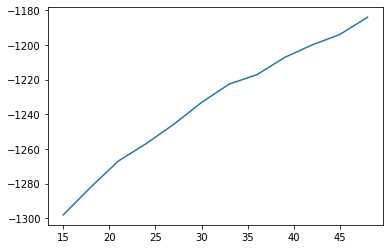

In [32]:
x = range(15,50)
print('Inertia:')
plt.plot(x, losses);

Silhouette score:


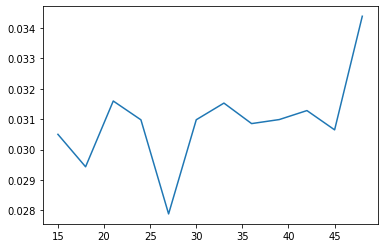

In [33]:
print('Silhouette score:')
plt.plot(x, silhouette_scores);

It looks like 20 & 47 clusters seems interesting numbers to further explore.

In [314]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 20, random_state=1)
kmeans.fit(embeddings)
print(f'Inertia: {kmeans.score(embeddings)}')
print(f'Silhouette scores: {silhouette_score(embeddings, kmeans.labels_)}')

Inertia: -1192.5897216796875
Silhouette scores: 0.016546668484807014


In [316]:
kmeans_47 = KMeans(n_clusters = 47, random_state=1)
kmeans_47.fit(embeddings)
print(f'Inertia: {kmeans_47.score(embeddings)}')
print(f'Silhouette scores: {silhouette_score(embeddings, kmeans_47.labels_)}')

Inertia: -1112.76708984375
Silhouette scores: 0.0175517238676548


But after discusion with the business team of American Airlines (aka our NLP teacher). We decided to go for 35 clusters. Indeed the metrics for unsupervised learning are really not perfect, so business knowledge will most of the time be more insightful.

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans_35 = KMeans(n_clusters = 35, random_state=1)
kmeans_35.fit(embeddings)
print(f'Inertia: {kmeans_35.score(embeddings)}')
print(f'Silhouette scores: {silhouette_score(embeddings, kmeans_35.labels_)}')

Inertia: -1215.0968017578125
Silhouette scores: 0.021248331293463707


In [12]:
# data['bert_kmeans_clusters'] = kmeans.labels_
# data['bert_kmeans_47clusters'] = kmeans_47.labels_
data['bert_kmeans_35clusters'] = kmeans_35.labels_
data.head()

,responce,question,langue,bert_vectors,bert_kmeans_35clusters
603,@115904 We'll be sure to pass along your kind words! #AATeam,erica team amazing give raise ty,1,"[-0.042830452, 0.0033645306, -0.00762816, 0.014212549, 0.068372495, 0.060131975, -0.06108707, 0.023269242, -0.054579534, -0.02880549, 0.02580337, 0.04805528, -0.03956774, 0.07162384, 0.025605988, -0.015029941, -0.036010917, 0.07752178, -0.0028177537, -0.013076511, 0.052667517, 0.0026162898, 0.015808508, 0.013886307, -0.03718728, 0.018579228, -0.014673145, 0.074385084, -0.024294289, -0.03180943, -0.009981542, -0.03329466, -0.04653384, -0.021632569, 1.6013689e-06, -0.027044807, -0.077066176, -...",3
605,@115904 Our apologies for the delay in responding to you. Have you made it to LAX? Let us know if you still need assistance.,could someone team available guide gate asap,1,"[0.020876044, 0.03373408, -0.03730834, 0.04945281, -0.0183955, 0.014309846, 0.015990604, -0.010458622, 0.021350361, -0.027525274, 0.030209452, 0.011135467, 0.0014646047, 0.031257655, -0.009953338, -0.06722267, 0.012159301, -0.020916037, -0.0053177583, -0.025816087, 0.013643312, 0.05238593, -0.061271194, 0.003623677, 0.012688841, -0.010534255, 0.0045564706, 0.01598113, 0.033383198, 0.016381817, -0.0010483678, -0.02527402, -0.02857663, -0.024139551, 1.6183155e-06, -0.0013259071, -0.010000101, ...",5
608,"@115905 Aww, that's definitely a future pilot in the making! #HappyHalloween",ben tennyson pilot . …,1,"[-0.008929651, 0.06484396, 0.032495033, -0.009288641, 0.008502924, 0.0039460524, 0.027906708, 0.0136236455, -0.06856497, -0.021749394, 0.026914258, -0.017214887, -0.012272861, 0.013218348, 0.023117177, 0.0054314057, 0.0017828323, -0.0020100235, 0.062044077, -0.010390789, -0.021098925, 0.015394811, -0.043410074, 0.016768014, 0.027112238, -0.023458108, 0.09346981, 0.011450346, 0.029201673, -0.00015037149, -0.015208454, 0.014709363, 0.042184323, 0.0401348, 1.8487254e-06, 0.06487959, 0.041352745...",34
612,@115906 We're sorry for your frustration.,"right , earned . also ’ pay pass spouse . need change program .",1,"[-0.03217489, 0.08505509, -0.011697191, 0.039517846, -0.015567623, 0.03125259, -0.01293914, 0.05513484, 0.013048691, -0.028603366, 0.06413592, 0.04027265, 0.027461449, 0.02202583, 0.010803952, 0.092469916, -0.055953097, 0.012029881, 0.045438394, -0.041170355, -0.0186616, 0.028493868, -0.054801907, 0.03076643, -0.010311727, -0.046284523, 0.052611567, 0.019676004, 0.042133853, 0.020716945, 0.07481377, 0.056581125, -0.058552947, -0.0016325366, 1.7709614e-06, -0.0018588227, -0.008963148, 0.00337...",18
618,@115909 We're glad you got to kick back and enjoy a show while flying! Thanks for your kind words.,"thank , playing great attendants back home !",1,"[-0.033029847, -0.052723926, -0.020886198, 0.01134514, 0.014481701, -0.014762324, 0.0074800747, 0.0005944651, -0.030104227, -0.016419565, -0.010901938, -0.038568933, -0.0146933915, 0.03135345, 0.058903363, -0.014872131, 0.0047037266, -0.014426683, -0.043511484, -0.023981038, 0.0020147434, -0.00075374596, -0.01026135, -0.02827919, -0.032739338, 0.07303833, 0.031102788, 0.022675911, 0.030187495, -0.03584585, 0.07961837, -0.027167307, 0.011765745, 0.032604683, 1.8933075e-06, -0.0016266234, -0.0...",3


In [75]:
data.bert_kmeans_35clusters.value_counts()

33    92
10    84
26    79
8     79
7     75
6     72
12    68
4     64
29    61
21    60
25    59
2     58
5     58
3     58
28    57
15    53
11    51
23    51
24    51
1     50
22    49
13    47
31    45
16    43
34    43
30    39
14    38
18    36
9     36
0     32
19    30
27    29
20    27
32    21
17    11
Name: bert_kmeans_35clusters, dtype: int64

Topics looks more or less balanced with Kmeans.

In [77]:
import pickle

# saving topics and model
data.to_csv('k_means_clusters.csv')
pickle.dump(kmeans_35, open('kmeans_35.sav', 'wb'))

### With HDBSCAN 

This algorithm is density based meaning that it might find different clusters than Kmeans. 

In [ ]:
# from sklearn.cluster import DBSCAN

# dbscan_grid = DBSCAN(eps = 0.5, min_samples = 5, n_jobs=12)
# clusters_db = dbscan_grid.fit_predict(data.bert_vectors)

In [11]:
import umap
import hdbscan


def get_clusters(embeddings,
                      n_neighbors,
                      n_components, 
                      min_cluster_size):
 
    umap_emb = (umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, 
                                metric='cosine', random_state=1)
                            .fit_transform(embeddings))
    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size, metric='euclidean', 
                               cluster_selection_method='eom').fit(umap_emb)
    
    return clusters


In [29]:
# tweak parameters
clusters = get_clusters(embeddings, 15, 5, 5)
clusters.labels_


array([-1, 43, 37, ..., 26, 21, -1])

In [28]:
data["bert_dbscan_clusters"] = clusters.labels_
print(clusters.labels_.max())
data.bert_dbscan_clusters.value_counts()

38


-1     836
 15    129
 38     95
 23     87
 12     64
 24     51
 7      45
 29     41
 33     34
 10     29
 11     28
 28     26
 18     23
 4      23
 14     19
 5      19
 31     17
 36     17
 20     17
 8      16
 35     13
 9      13
 21     13
 0      13
 34     12
 30     12
 25     10
 19     10
 2       9
 37      9
 6       9
 26      9
 16      8
 32      8
 13      8
 22      7
 3       7
 17      7
 1       7
 27      6
Name: bert_dbscan_clusters, dtype: int64

DBSCAN is also used for anomaly detection and here it finds far too much anomalies (cluster = -1). It's not a good clustering aglorithm for our embeddings.

### Using similarity matrix (based on cosine similarity) and hierarchical clustering. 

In [17]:
from scipy.cluster import  hierarchy
from sklearn.metrics.pairwise import pairwise_distances


# build similarity matrix 
cos_sim_matrix = hierarchy.linkage(embeddings, "average", metric="cosine")
# cos_sim_matrix = pairwise_distances(umap_embeddings, metric='cosine', n_jobs=12)

In [58]:
# tweak threshold
threshold = 0.75
clusters = hierarchy.fcluster(cos_sim_matrix, threshold, criterion="distance")


In [59]:
data["bert_hierarchical_clusters"] = clusters
print(data["bert_hierarchical_clusters"].nunique())
data["bert_hierarchical_clusters"].value_counts()

162


125    312
128    311
127    155
95      98
131     67
75      34
106     30
118     25
115     23
113     23
76      22
92      22
126     20
105     19
94      18
104     17
112     17
117     17
77      16
82      16
55      14
129     13
79      12
87      12
88      12
110     12
124     11
81      11
108     11
72      10
85      10
130     10
63       9
102      9
59       9
37       8
100      8
50       8
123      8
68       8
54       7
114      7
43       7
120      7
74       6
116      6
93       6
44       6
62       6
122      6
15       5
52       5
73       5
19       5
96       5
49       5
83       5
6        5
80       5
141      5
45       5
103      5
70       5
9        4
121      4
101      4
154      4
111      4
151      4
119      4
109      4
138      4
160      4
3        3
56       3
140      3
150      3
4        3
149      3
47       3
90       3
153      3
64       3
69       3
99       3
147      3
78       3
42       3
107      3
33       3
91       3

Same as for DBSCAN, clusters are really unbalanced, we will stick with Kmeans for now.

## Intents extraction

A basic approach using spacy to get an idea about our clusters.

In [78]:
data_kmeans = pd.read_csv('k_means_clusters.csv', index_col='Unnamed: 0')
kmeans_35 = pickle.load(open("kmeans_35.sav", 'rb'))
data_kmeans.head(1)

,responce,question,langue,bert_vectors,bert_kmeans_35clusters
603,@115904 We'll be sure to pass along your kind words! #AATeam,erica team amazing give raise ty,1,[-4.28304523e-02 3.36453062e-03 -7.62816006e-03 1.42125487e-02\n 6.83724955e-02 6.01319745e-02 -6.10870682e-02 2.32692417e-02\n -5.45795336e-02 -2.88054906e-02 2.58033704e-02 4.80552800e-02\n -3.95677388e-02 7.16238394e-02 2.56059878e-02 -1.50299408e-02\n -3.60109173e-02 7.75217786e-02 -2.81775370e-03 -1.30765112e-02\n 5.26675172e-02 2.61628977e-03 1.58085078e-02 1.38863074e-02\n -3.71872783e-02 1.85792278e-02 -1.46731446e-02 7.43850842e-02\n -2.42942888e-02 -3.18094306e-02 -...,3


In [14]:
import collections


def most_common(lst, n_words):
    
    counter=collections.Counter(lst)
    return counter.most_common(n_words)

def extract_labels(list_docs):

    verbs = []
    dobjs = []
    nouns = []
    adjs = []
    
    verb = ''
    dobj = ''
    noun1 = ''
    noun2 = ''

    # for each document, append verbs, dobs, nouns, and adjectives to 
    # running lists for whole cluster
    for i in range(len(list_docs)):
        doc = nlp(list_docs[i])
        for token in doc:
            if token.is_stop==False:
                if token.dep_ == 'ROOT':
                    verbs.append(token.text.lower())
                elif token.dep_=='dobj':
                    dobjs.append(token.lemma_.lower())
                elif token.pos_=='NOUN':
                    nouns.append(token.lemma_.lower())     
                elif token.pos_=='ADJ':
                    adjs.append(token.lemma_.lower())
    
    # take most common words of each kind
    if len(verbs) > 0:
        verb = most_common(verbs, 1)[0][0]
    if len(dobjs) > 0:
        dobj = most_common(dobjs, 1)[0][0]
    if len(nouns) > 0:
        noun1 = most_common(nouns, 1)[0][0]
    if len(set(nouns)) > 1:
        noun2 = most_common(nouns, 2)[1][0]
    
    # concatenate the most common words of each kind
    label_words = [verb, dobj]
    
    for word in [noun1, noun2]:
        if word not in label_words:
            label_words.append(word)

    if '' in label_words:
        label_words.remove('')
    
    label = '_'.join(label_words)
    
    return label

In [357]:
# data['question'] = data['question'].apply(lambda x: " ".join(x))

intents = {}
for cluster in data['bert_kmeans_35clusters'].unique().tolist():
    intents['cluster_' + str(cluster)] = extract_labels(data[data['bert_kmeans_35clusters']==cluster]['question'].tolist())

In [358]:
intents

{'cluster_18': 'got_raise_flight_attendant',
 'cluster_23': 'waiting_flight_gate_airport',
 'cluster_30': 'want_plane_flight',
 'cluster_1': 'thanks_mile_ticket_way',
 'cluster_31': 'thank_flight_service',
 'cluster_24': 'fly_wifi_airline_flight',
 'cluster_12': 'like_lounge_flagship',
 'cluster_14': 'tried_app_flight',
 'cluster_33': 'need_flight_ticket',
 'cluster_27': 'said_money_guy_people',
 'cluster_22': 'charged_bag_flight',
 'cluster_16': 'thanks_seat_row',
 'cluster_5': 'waiting_refund_day_ticket',
 'cluster_29': 'want_seat_flight',
 'cluster_0': 'going_flight_plane',
 'cluster_6': 'delayed_flight_hour',
 'cluster_8': 'delayed_flight_hour',
 'cluster_19': 'check_bag_gate',
 'cluster_7': 'flying_flight_day_way',
 'cluster_17': 'got_flight_aa',
 'cluster_26': 'thank_service_medium_team',
 'cluster_15': 'need_character_password',
 'cluster_34': 'service_customer',
 'cluster_11': 'flying_flight_time',
 'cluster_4': 'refused_passenger_flight_class',
 'cluster_32': 'fees_bag_carry',

However, this model work based on statistical properties of a text (such as count) and not so much on semantic similarity. Let's try something a bit more advanced.


### Intents extraction with Bert


In [19]:
from keybert import KeyBERT

# off the shelf, BERT based key word extractor
kw_model = KeyBERT()

In [124]:
def create_patterns(question):
    
    import operator
    
    two = kw_model.extract_keywords(question, keyphrase_ngram_range=(1, 2),stop_words=None)
    three = kw_model.extract_keywords(question, keyphrase_ngram_range=(1, 3),stop_words=None)
    four = kw_model.extract_keywords(question, keyphrase_ngram_range=(1, 4),stop_words=None)

    final_patterns = two + three + four
    if len(final_patterns) != 0 :
        result = max(final_patterns,key=operator.itemgetter(1))[0]
    else :
        result = ''

    return result


def create_tags(question):
    
    import operator
    tag = kw_model.extract_keywords(question, keyphrase_ngram_range=(1, 1),stop_words=None)
    if len(tag) != 0 :
            result = max(tag,key=operator.itemgetter(1))[0]
    else :
        result = ''
    return result

In [103]:
from tqdm import tqdm

intents = {}
for cluster in tqdm(data['bert_kmeans_35clusters'].unique().tolist()):
    intents['cluster_' + str(cluster)] = create_patterns(re.sub("\d+", " ", " ".join(data[data['bert_kmeans_35clusters']==cluster]['question_'].tolist())))

100%|███████████████████████████████████████████| 35/35 [01:15<00:00,  2.17s/it]


In [104]:
intents

{'cluster_10': 'club much great crew',
 'cluster_26': 'hours gate gate agents',
 'cluster_33': 'pilot pilot smoothest',
 'cluster_27': 'service line unfair guys',
 'cluster_1': 'attendants always rude flown',
 'cluster_16': 'worth membership way trips',
 'cluster_28': 'reservation got ticket get',
 'cluster_4': 'way paid upgraded seats',
 'cluster_6': 'accidentally something account say',
 'cluster_31': 'gone airport extends courtesy',
 'cluster_32': 'waiting compensate crap put',
 'cluster_23': 'theres taxis tips relax',
 'cluster_19': 'give grief things go',
 'cluster_14': 'carry bag room overhead',
 'cluster_18': 'legroom passengers',
 'cluster_13': 'crew terminal awful night',
 'cluster_22': 'delayed cant find pilots',
 'cluster_15': 'airline taking',
 'cluster_12': 'family get traveling yo',
 'cluster_2': 'bag fee returned bags',
 'cluster_9': 'cancellation due pilot shortage',
 'cluster_17': 'responsive helpful making bad',
 'cluster_8': 'boarding pass except',
 'cluster_11': 'th

### Getting the tag of clusters

In [125]:
from tqdm import tqdm

tags = {}
for cluster in tqdm(data['bert_kmeans_35clusters'].unique().tolist()):
    tags['cluster_' + str(cluster)] = create_tags(re.sub("\d+", " ", " ".join(data[data['bert_kmeans_35clusters']==cluster]['question'].tolist())))

100%|███████████████████████████████████████████| 35/35 [00:07<00:00,  4.44it/s]


In [126]:
tags

{'cluster_10': 'amaze',
 'cluster_26': 'gate',
 'cluster_33': 'pilot',
 'cluster_27': 'attendant',
 'cluster_1': 'attendant',
 'cluster_16': 'airport',
 'cluster_28': 'booking',
 'cluster_4': 'surcharge',
 'cluster_6': 'ban',
 'cluster_31': 'airport',
 'cluster_32': 'message',
 'cluster_23': 'taxiway',
 'cluster_19': 'grief',
 'cluster_14': 'baggage',
 'cluster_18': 'seating',
 'cluster_13': 'crew',
 'cluster_22': 'delay',
 'cluster_15': 'airline',
 'cluster_12': 'travel',
 'cluster_2': 'baggage',
 'cluster_9': 'cancellation',
 'cluster_17': 'feedback',
 'cluster_8': 'boarding',
 'cluster_11': 'thankful',
 'cluster_30': 'service',
 'cluster_21': 'customer',
 'cluster_34': 'baggage',
 'cluster_25': 'staff',
 'cluster_7': 'day',
 'cluster_0': 'meal',
 'cluster_24': 'locator',
 'cluster_20': 'upgrade',
 'cluster_5': 'reimburse',
 'cluster_29': 'voucher',
 'cluster_3': 'reschedule'}

It's hard too tell, but we think the first method is the best here to understand our clusters.

## Chatbot (without greetings)
 
Ok now we have extracted our intents we can build the chatbot, this requires several steps:

- process the user input
- find the corresponding intent
- among the questions belonging to this intent, find the closest from the input, using cosine similarity.
- process and provide the corresponding answer.

In [33]:
import pickle
import pandas as pd
from sentence_transformers import SentenceTransformer


# loading models
model = SentenceTransformer('all-mpnet-base-v2')
kmeans_35 = pickle.load(open("kmeans_35.sav", 'rb'))
# data_kmeans = pd.read_csv('k_means_clusters.csv', index_col='Unnamed: 0')
data.head(1)

,responce,question,langue,bert_vectors,bert_kmeans_35clusters
603,@115904 We'll be sure to pass along your kind words! #AATeam,erica team amazing give raise ty,1,"[-0.042830452, 0.0033645306, -0.00762816, 0.014212549, 0.068372495, 0.060131975, -0.06108707, 0.023269242, -0.054579534, -0.02880549, 0.02580337, 0.04805528, -0.03956774, 0.07162384, 0.025605988, -0.015029941, -0.036010917, 0.07752178, -0.0028177537, -0.013076511, 0.052667517, 0.0026162898, 0.015808508, 0.013886307, -0.03718728, 0.018579228, -0.014673145, 0.074385084, -0.024294289, -0.03180943, -0.009981542, -0.03329466, -0.04653384, -0.021632569, 1.6013689e-06, -0.027044807, -0.077066176, -...",3


In [36]:
def process_input(question):
 
    import re
    question = re.sub('@[\w]+','',question) #delate @
    question = re.sub('#[^\s]+','',question) #delate hastag
    question = clean_url(question)
    question = clean_html(question)
    question = remove_emoji(question)
    question = clean_punctuation(question)
    
    if get_english(question):
        question = remove_stops(question.lower())
        # question = remove_non_english(question)
        
        if question == "":
            print('Sorry, I do not understand!')
    else:
        ('Please, talk to me in english!')
 
    return question

def encode_input(cleaned_question):
    embedding = model.encode(cleaned_question, show_progress_bar=True)
    return embedding


def predict_intent(embedding):
    intent = kmeans_35.predict(embedding.reshape(1, -1))
    return intent



Some example inputs to illustrate the process.

In [35]:
test1 = "@AmericanAir I am a regular client of your company and I was sitted right next to a woman with a huge dog. And guess what ? I am allergic, how could you allow a 40lb dog to travel among all passengers ? Seriously It's ridiculous..."
test2 = "@AmericanAir You guys are always late, my flight is reschedule for the third time now... I can't believe this is happening to me again... I can afford to be late at work!"


# cleaning and vectorizing the user input
vectorized_query = encode_input(process_input(test1))

# predict the intent of it
int(predict_intent(vectorized_query))

Batches: 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]


6

We have the intent, so now we can subset the dataset according to that intent

In [408]:
subset_intent = data[data['bert_kmeans_35clusters'] == int(predict_intent(vectorized_query))]
subset_intent.head()

,responce,question,langue,bert_vectors,bert_kmeans_35clusters
2708,@116577 Any dogs you see outside of a kennel are either service or emotional support animals.,"’ missing point . numerous people tripped dog , mention anyone might allergic . change policy allow size dog cabins any/no reason ?",1,"[0.019941103, -0.004907608, -0.0216171, -0.005585694, 0.031978812, 0.013888998, 0.06464607, 0.028766025, 0.037617676, -0.0028157907, 0.03133589, 0.033286024, -0.064723894, -0.0029695826, 0.018896658, 0.022669671, 0.0032928328, 0.009101168, -0.04615694, -0.018063793, -0.0043026083, -0.0058758133, -0.0057010655, -0.0017028486, 0.03471668, 0.029610794, -0.015120311, -0.030667445, 0.030693904, -0.09859003, 0.017937621, -0.06099298, 0.056220766, -0.0021184098, 1.4605016e-06, 0.03779077, -0.035800...",6
4562,"@117169 Oh my, we'd like to have more details about what happened. We always expect our team to treat our customers courteously and friendly.","interacted one rudest attendants 1305 ord slc . patient , 's 4 .",1,"[0.0193409, -0.040967677, 0.0029913886, 0.043220628, 0.015281247, 0.023483228, 0.043141637, 0.00888277, -0.023995077, 0.030567506, 0.028364982, -0.040634938, -0.002011723, -0.018827053, -0.015872188, 0.028817305, 0.026407236, 0.0081881, -0.020659061, 0.012174327, -0.03381198, 0.013956402, -0.041634835, 0.029872416, -0.008017442, 0.022238312, 0.0136669045, 0.024514796, 0.041725792, -0.020997101, 0.08472193, 0.003538265, -0.012988361, 0.07707981, 1.8862413e-06, -0.014254608, 0.030600594, 0.032...",6
4791,@117240 We want to make sure communication is crystal clear. Please DM your record locator so we can share your feedback.,might good idea 2 working intercoms flights.flight attendant literally sounds like adults talking charlie brown,1,"[0.014428796, 0.059674997, -0.012037892, 0.0053907107, -0.0016390622, 0.010717492, 0.08590115, 0.008355415, -0.06536237, 0.027348455, -0.023571568, -0.08685961, -0.006141257, -0.017219562, 0.0059268805, 0.00086474646, -0.019501109, -0.042360302, -0.008528918, -0.012924929, -0.017408704, 0.021890573, -0.030365054, 0.011936902, -0.0085192975, 0.03934497, 0.049262054, 0.010332767, 0.031089215, 0.011980173, 0.07001434, 0.02051775, -0.0021518262, 0.04696523, 1.4659521e-06, 0.0387265, 0.028057527,...",6
7266,@117992 No problem at all. It’s a huge honor for us to support our troops.,extends courtesy every every airport . guess spoiled . thank ur patriotism,1,"[-0.04100923, -0.024521094, -0.007926439, 0.030299803, -0.0070702266, -0.017769411, 0.037915904, -0.03690842, -0.002167035, -0.0069213337, -0.0016884161, -0.011797779, -0.00501809, -0.030108318, 0.0048918766, 0.029450022, 0.013144511, -0.04678468, -0.043816388, -0.0494837, -0.028091177, 0.028538296, -0.014600648, -0.012067497, -0.017550886, 0.066612035, 0.0734596, -0.0058549293, 0.056001555, -0.022256361, 0.05445566, 0.0024471262, 0.038176324, -0.010516581, 1.6540228e-06, -0.023542032, 0.039...",6
9544,@118743 Please DM your record locator. We'd like to share this feedback with the Flight Service leadership team.,comment ’ address problematic comment made attendant .,1,"[0.10750002, -0.024768135, 0.0011373035, 0.07505461, 0.028067058, 0.048994884, 0.06295916, 0.013057833, -0.054938585, -0.050252527, 0.015565306, -0.015696786, 0.0113104405, -0.060148362, 0.031577054, 0.03322621, 0.02599203, 0.012045059, 0.014371287, -0.010610244, -0.0087413695, 0.020397222, -0.012299838, 0.02811512, -0.04806228, 0.02100706, 0.037713185, 0.009778312, 0.028147966, -0.010626361, 0.06832403, -0.0027342278, 0.007258156, -0.024819054, 1.3524857e-06, -0.025773114, 0.029210512, 0.03...",6


Now, among this subset corresponding to the predicted intent, we can find the closest question according to cosine similarity. Then we get the corresponding answer.

In [409]:
from scipy.spatial import distance

subset_intent['cosine_similarity'] = subset_intent['bert_vectors'].apply(lambda x: 1 - distance.cosine(x, vectorized_query))
subset_intent.sort_values(by=['cosine_similarity'], ascending=False).head()

/tmp/ipykernel_9110/1443037527.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_intent['cosine_similarity'] = subset_intent['bert_vectors'].apply(lambda x: 1 - distance.cosine(x, vectorized_query))


,responce,question,langue,bert_vectors,bert_kmeans_35clusters,cosine_similarity
2708,@116577 Any dogs you see outside of a kennel are either service or emotional support animals.,"’ missing point . numerous people tripped dog , mention anyone might allergic . change policy allow size dog cabins any/no reason ?",1,"[0.019941103, -0.004907608, -0.0216171, -0.005585694, 0.031978812, 0.013888998, 0.06464607, 0.028766025, 0.037617676, -0.0028157907, 0.03133589, 0.033286024, -0.064723894, -0.0029695826, 0.018896658, 0.022669671, 0.0032928328, 0.009101168, -0.04615694, -0.018063793, -0.0043026083, -0.0058758133, -0.0057010655, -0.0017028486, 0.03471668, 0.029610794, -0.015120311, -0.030667445, 0.030693904, -0.09859003, 0.017937621, -0.06099298, 0.056220766, -0.0021184098, 1.4605016e-06, 0.03779077, -0.035800...",6,0.721346
165806,"@162591 Your comments concern us, service animals are welcome on board if they meet requirements. Please DM some additional details.","harassing service dog & ; yelling license , really great way treat disabled passengers",1,"[0.0120343985, 0.03918638, 0.011316754, -0.013351571, -0.0011051093, 0.043053478, 0.07687392, 0.034477897, -0.0374002, -0.032502696, 0.02587848, 0.05531184, -0.015721345, -0.012173167, -0.00687013, -0.017690364, -0.0025414717, 0.0028585424, 0.023136841, -0.04097612, -0.012675235, 0.014907694, -0.018480884, 0.025580257, -0.031059088, 0.03991676, 0.037321143, 0.015585828, 0.08703588, -0.09751599, 0.0045243157, -0.02829027, 0.014287325, 0.037151564, 1.2090011e-06, 0.010610217, -0.00088258187, 0...",6,0.649292
116843,"@148703 We'd like to help, and encourage you to send us a DM with the cargo shipping details on your furry friend.",flew fam home thanksgiving husband deployed cheer kids . 's stressful trip thanks cargo . terrible service & ; staff n't helpful giving accurate info shipping dog .,1,"[0.015265258, 0.0024983129, -0.026950223, -0.00930093, -0.002611777, 0.019893788, 0.022034151, 0.03640407, -0.06019559, -0.04497301, 0.017479245, 6.6361215e-05, 0.027734458, 0.050545532, -0.006065772, 0.037056733, 0.050290518, -0.01156415, -0.06745149, -0.03840999, -0.031434063, 0.007949804, -0.0517855, 0.008663543, -0.009983293, 0.0073636584, -0.020533811, 0.053143118, 0.030936623, -0.087912425, 0.062403332, -0.021068614, -0.0020646944, 0.022940213, 2.0149052e-06, 0.003086647, -0.031838402,...",6,0.491193
69561,@135471 We definitely want to keep families flying this holiday season and fully expect to avoid any cancellations.,"previous years , complained , one gave poop ! fact yr baby cried till . fussing husband & ; mom , getting help baby almost fell tarmac bridge . attendant threatened throw ! even acting wild .",1,"[-0.0029673816, 0.04226523, -0.012233615, 0.0052738134, -0.0007847944, -0.009925255, -0.019602045, 0.01412271, -0.07342135, -0.045617957, 0.076577686, -0.057490822, -0.0132762045, 0.0035805374, -0.04294686, 0.0031142463, 0.0038870361, -0.01029153, -0.029974723, 0.013130828, -0.011261489, 0.017865794, -0.0035415662, 0.01381836, -0.05548751, 0.020774115, 0.022960411, 0.020851994, 0.0006317582, -0.06534657, 0.07664578, 0.0037343472, 0.045385342, 0.07073427, 1.5672108e-06, 0.015980422, -0.022511...",6,0.481006
90969,@141669 Sharon is truly one of a kind and yet again this goes to prove how #AAmazing she is. We'll be sure to pass your kudos along. #AATeam,". wonderful booking experience - traveling w/ 2 small poodles . 1 emotional support . anxious process , special services rep , sharon , amazing put completely ease .",1,"[0.011245241, -0.008530712, -0.024801826, 0.035152458, -0.012648453, 0.013389804, 0.00331213, 0.05716098, -0.07639315, 0.0013229937, -0.02563098, -0.036300056, 0.03582617, 0.0370557, -0.0057717366, -0.004112909, 0.040112063, -0.011310159, -0.04519837, 0.01143345, -0.045678813, 0.013526977, -0.09896839, 0.036567252, 0.028410507, -0.03288119, -0.06453309, 0.0672273, 0.06397794, -0.03202529, 0.0022711062, -0.036448997, 0.0021409937, 0.01093745, 1.604563e-06, 0.022059651, 

But know we have to process this anwser : removing the person names, places, prices...

In [40]:
def remove_names(df):
    tagged_sentence = nltk.tag.pos_tag(df.split())
    edited_sentence = [word for word,tag in tagged_sentence if tag != 'NNP']
    df_final = ' '.join(edited_sentence)
    return df_final


def remove_stops_anwsers(df):
    custom_stopwords = set(stopwords.words("english"))
    return ' '.join([t for t in df.split()  if not t in custom_stopwords])


words = set(nltk.corpus.words.words())
def english_words(sent):
    from textblob import Word
    url = re.search("(?P<url>https?://[^\s]+)", sent)
    if url is not None:
        url = url.group(0)
    return " ".join(w for w in sent.split() if Word(w.lower()).lemmatize() in words or w == url  or w.isdigit())

In [39]:
def process_answer(answer):
 
    import re
    answer = re.sub('@[\w]+','',answer) #delate @
    answer = re.sub('#[^\s]+','',answer) #delate hastag
    # remove numbers below 6 figures (to keep phone number in anwsers)
    answer = re.sub('(\A|[^0-9])([0-9]{1,6})([^0-9]|$)', '', answer) 
    # question = clean_url(question)
    # answer = remove_stops_anwsers(anwser)
    answer = remove_names(answer)
    answer = remove_emoji(answer)
    # answer = english_words(answer)
    
    # question = clean_punctuation(question)
 
    return answer.capitalize()



In [412]:
anwser = subset_intent.sort_values(by=['cosine_similarity'], ascending=False).responce.iat[0]
print(test2)
print(anwser)
print(process_answer(anwser))

@AmericanAir You guys are always late, my flight is reschedule for the third time now... I can't believe this is happening to me again... I can afford to be late at work!
@116577 Any dogs you see outside of a kennel are either service or emotional support animals.
Any dogs you see outside of a kennel are either service or emotional support animals.


## Chatbot with greetings 

We failed to add the greetings synthetic dataset and find relevant cluster with our initial pipeline. This has been adding a lot of noise in the data. So we will try a different approach here.

Since we made up this greeting dataset, we already know the intents of it. We are going to make this rule based chatbot a supervised learning tasks : with the intents with found in the american airlines dataset and with the synthetic topics we labelled.

In [14]:
extra_data = pd.read_csv('question_responce suppl.csv', index_col='Unnamed: 0')
extra_data.head()

,responce,question,langue,bert_kmeans_35clusters
203634,Hi !,"Hi there, how can I help?",1,35
203635,How are you ?,"Hi there, how can I help?",1,35
203636,Is anyone there?,"Good to see you, what can i do for you?",1,35
203637,Hello !,"Hello, how can I help you?",1,35
203638,Hey !,"Hello, how can I help you?",1,35


In [15]:
embeddings_suppl = model.encode(extra_data.question.tolist(), show_progress_bar=True)

Batches: 100%|██████████| 6/6 [00:01<00:00,  3.46it/s]


In [16]:
extra_data['bert_vectors'] = list(embeddings_suppl)
extra_data.head()

,responce,question,langue,bert_kmeans_35clusters,bert_vectors
203634,Hi !,"Hi there, how can I help?",1,35,"[0.04144959, -0.005290745, -0.030423084, 0.029895034, 0.008074511, 0.010434585, -0.027699664, 0.017426372, 0.05244801, -0.03729783, 0.013165434, -0.017059041, -0.008158231, 0.029116305, -0.026283376, -0.07493479, 0.010359083, 0.020400124, 0.026299704, -0.04182361, 0.085000426, -0.032904096, -0.010974228, -0.021302132, -0.048616953, 0.00016592571, 0.037767656, -0.005562994, 0.056574438, -0.021134185, 0.084714755, 0.0082029365, -0.02009218, -0.02453469, 2.0431228e-06, -0.04244198, 0.022714876,..."
203635,How are you ?,"Hi there, how can I help?",1,35,"[0.04144959, -0.005290745, -0.030423084, 0.029895034, 0.008074511, 0.010434585, -0.027699664, 0.017426372, 0.05244801, -0.03729783, 0.013165434, -0.017059041, -0.008158231, 0.029116305, -0.026283376, -0.07493479, 0.010359083, 0.020400124, 0.026299704, -0.04182361, 0.085000426, -0.032904096, -0.010974228, -0.021302132, -0.048616953, 0.00016592571, 0.037767656, -0.005562994, 0.056574438, -0.021134185, 0.084714755, 0.0082029365, -0.02009218, -0.02453469, 2.0431228e-06, -0.04244198, 0.022714876,..."
203636,Is anyone there?,"Good to see you, what can i do for you?",1,35,"[0.021577213, -0.018705582, -0.01411042, -0.053509828, 0.030905388, 0.029784491, -0.059820678, -0.00020732067, 0.042898137, -0.07180767, -0.051104918, -0.0010535975, 0.055671804, 0.00908685, 0.07265569, -0.10365003, 0.035366632, -0.024876269, 0.073716044, -0.036032062, 0.03644692, -0.0247611, -0.004494427, -0.015267275, -0.025903398, -2.6341771e-05, 0.017026644, 0.041558318, 0.038424302, 0.016280368, -0.006114492, -0.010574463, -0.009085478, -0.093861654, 1.7027671e-06, -0.006396804, 0.05124..."
203637,Hello !,"Hello, how can I help you?",1,35,"[0.033737067, 0.008721039, -0.02251804, 0.022312328, -0.01629114, 0.037744936, -0.014925007, 0.015415451, 0.030435676, -0.020164436, -0.00037501485, -0.003719237, 0.01762301, 0.01823256, 0.012304791, -0.09590574, 0.035916466, -2.7873266e-06, 0.024452815, -0.018825488, 0.04863945, -0.01178851, -0.057931513, 0.0051610107, -0.03247865, -0.021967556, 0.04761522, -0.014288692, 0.07796605, 0.028216561, 0.057963334, -0.009269945, -0.021161407, -0.03629033, 2.0842788e-06, -0.01609232, 0.014884227, 0..."
203638,Hey !,"Hello, how can I help you?",1,35,"[0.033737067, 0.008721039, -0.02251804, 0.022312328, -0.01629114, 0.037744936, -0.014925007, 0.015415451, 0.030435676, -0.020164436, -0.00037501485, -0.003719237, 0.01762301, 0.01823256, 0.012304791, -0.09590574, 0.035916466, -2.7873266e-06, 0.024452815, -0.018825488, 0.04863945, -0.01178851, -0.057931513, 0.0051610107, -0.03247865, -0.021967556, 0.04761522, -0.014288692, 0.07796605, 0.028216561, 0.057963334, -0.009269945, -0.021161407, -0.03629033, 2.0842788e-06, -0.01609232, 0.014884227, 0..."


In [17]:
extra_data = extra_data.reindex(columns=['responce', 'question', 'langue', 'bert_vectors', 'bert_kmeans_35clusters'])
extra_data.head()

,responce,question,langue,bert_vectors,bert_kmeans_35clusters
203634,Hi !,"Hi there, how can I help?",1,"[0.04144959, -0.005290745, -0.030423084, 0.029895034, 0.008074511, 0.010434585, -0.027699664, 0.017426372, 0.05244801, -0.03729783, 0.013165434, -0.017059041, -0.008158231, 0.029116305, -0.026283376, -0.07493479, 0.010359083, 0.020400124, 0.026299704, -0.04182361, 0.085000426, -0.032904096, -0.010974228, -0.021302132, -0.048616953, 0.00016592571, 0.037767656, -0.005562994, 0.056574438, -0.021134185, 0.084714755, 0.0082029365, -0.02009218, -0.02453469, 2.0431228e-06, -0.04244198, 0.022714876,...",35
203635,How are you ?,"Hi there, how can I help?",1,"[0.04144959, -0.005290745, -0.030423084, 0.029895034, 0.008074511, 0.010434585, -0.027699664, 0.017426372, 0.05244801, -0.03729783, 0.013165434, -0.017059041, -0.008158231, 0.029116305, -0.026283376, -0.07493479, 0.010359083, 0.020400124, 0.026299704, -0.04182361, 0.085000426, -0.032904096, -0.010974228, -0.021302132, -0.048616953, 0.00016592571, 0.037767656, -0.005562994, 0.056574438, -0.021134185, 0.084714755, 0.0082029365, -0.02009218, -0.02453469, 2.0431228e-06, -0.04244198, 0.022714876,...",35
203636,Is anyone there?,"Good to see you, what can i do for you?",1,"[0.021577213, -0.018705582, -0.01411042, -0.053509828, 0.030905388, 0.029784491, -0.059820678, -0.00020732067, 0.042898137, -0.07180767, -0.051104918, -0.0010535975, 0.055671804, 0.00908685, 0.07265569, -0.10365003, 0.035366632, -0.024876269, 0.073716044, -0.036032062, 0.03644692, -0.0247611, -0.004494427, -0.015267275, -0.025903398, -2.6341771e-05, 0.017026644, 0.041558318, 0.038424302, 0.016280368, -0.006114492, -0.010574463, -0.009085478, -0.093861654, 1.7027671e-06, -0.006396804, 0.05124...",35
203637,Hello !,"Hello, how can I help you?",1,"[0.033737067, 0.008721039, -0.02251804, 0.022312328, -0.01629114, 0.037744936, -0.014925007, 0.015415451, 0.030435676, -0.020164436, -0.00037501485, -0.003719237, 0.01762301, 0.01823256, 0.012304791, -0.09590574, 0.035916466, -2.7873266e-06, 0.024452815, -0.018825488, 0.04863945, -0.01178851, -0.057931513, 0.0051610107, -0.03247865, -0.021967556, 0.04761522, -0.014288692, 0.07796605, 0.028216561, 0.057963334, -0.009269945, -0.021161407, -0.03629033, 2.0842788e-06, -0.01609232, 0.014884227, 0...",35
203638,Hey !,"Hello, how can I help you?",1,"[0.033737067, 0.008721039, -0.02251804, 0.022312328, -0.01629114, 0.037744936, -0.014925007, 0.015415451, 0.030435676, -0.020164436, -0.00037501485, -0.003719237, 0.01762301, 0.01823256, 0.012304791, -0.09590574, 0.035916466, -2.7873266e-06, 0.024452815, -0.018825488, 0.04863945, -0.01178851, -0.057931513, 0.0051610107, -0.03247865, -0.021967556, 0.04761522, -0.014288692, 0.07796605, 0.028216561, 0.057963334, -0.009269945, -0.021161407, -0.03629033, 2.0842788e-06, -0.01609232, 0.014884227, 0...",35


In [40]:
extra_data.bert_vectors.head(1)

203634    [0.03138885, -0.06662785, -0.014790138, -0.0098734135, 0.0070758075, 0.032561846, 0.017180264, 0.01291915, 0.0777736, -0.0292635, -0.011801189, -0.078211196, 0.02370826, 0.09880414, 0.0013034958, -0.10994926, -0.011055484, 0.02025685, -0.051953066, -0.030425217, 0.015830478, 0.0022211918, 0.008532129, 0.043706037, 0.014239976, -0.03945647, 0.022131328, 0.019933885, -0.027604941, -0.004125864, 0.03592287, -0.0059972517, 0.017576214, -0.03948228, 2.0300715e-06, -0.014348894, -0.042249896, -0.0...
Name: bert_vectors, dtype: object

In [42]:
data.bert_vectors.head(1)

603    [-0.042830452, 0.0033645306, -0.00762816, 0.014212549, 0.068372495, 0.060131975, -0.06108707, 0.023269242, -0.054579534, -0.02880549, 0.02580337, 0.04805528, -0.03956774, 0.07162384, 0.025605988, -0.015029941, -0.036010917, 0.07752178, -0.0028177537, -0.013076511, 0.052667517, 0.0026162898, 0.015808508, 0.013886307, -0.03718728, 0.018579228, -0.014673145, 0.074385084, -0.024294289, -0.03180943, -0.009981542, -0.03329466, -0.04653384, -0.021632569, 1.6013689e-06, -0.027044807, -0.077066176, -...
Name: bert_vectors, dtype: object

In [18]:
data_full = data.append(extra_data, ignore_index=True)
data_full.tail()

,responce,question,langue,bert_vectors,bert_kmeans_35clusters
1976,Thank you for taking the time to do this,My pleasure,1,"[-0.031142078, -0.06967088, 0.0040144166, -0.020677518, 0.016974067, 0.035821293, 0.0481549, -0.036561247, -0.030646395, 0.031542584, -0.014684711, -0.0016794581, 0.009097712, 0.031373393, 0.088422954, -0.028129455, -0.055544626, 0.03327155, -0.03738446, -0.018758316, 0.0063856724, -0.007508528, -0.041673947, -0.023873983, -0.0034726406, -0.010205084, 0.012690611, 0.055861317, -0.03107079, -0.103001095, 0.0117878765, -0.015880428, -0.04760599, -0.03594868, 1.5173846e-06, 0.036769107, 0.00591...",41
1977,Many thanks,My pleasure,1,"[-0.031142078, -0.06967088, 0.0040144166, -0.020677518, 0.016974067, 0.035821293, 0.0481549, -0.036561247, -0.030646395, 0.031542584, -0.014684711, -0.0016794581, 0.009097712, 0.031373393, 0.088422954, -0.028129455, -0.055544626, 0.03327155, -0.03738446, -0.018758316, 0.0063856724, -0.007508528, -0.041673947, -0.023873983, -0.0034726406, -0.010205084, 0.012690611, 0.055861317, -0.03107079, -0.103001095, 0.0117878765, -0.015880428, -0.04760599, -0.03594868, 1.5173846e-06, 0.036769107, 0.00591...",41
1978,I’m beyond grateful,My pleasure,1,"[-0.031142078, -0.06967088, 0.0040144166, -0.020677518, 0.016974067, 0.035821293, 0.0481549, -0.036561247, -0.030646395, 0.031542584, -0.014684711, -0.0016794581, 0.009097712, 0.031373393, 0.088422954, -0.028129455, -0.055544626, 0.03327155, -0.03738446, -0.018758316, 0.0063856724, -0.007508528, -0.041673947, -0.023873983, -0.0034726406, -0.010205084, 0.012690611, 0.055861317, -0.03107079, -0.103001095, 0.0117878765, -0.015880428, -0.04760599, -0.03594868, 1.5173846e-06, 0.036769107, 0.00591...",41
1979,Thanks in advance,My pleasure,1,"[-0.031142078, -0.06967088, 0.0040144166, -0.020677518, 0.016974067, 0.035821293, 0.0481549, -0.036561247, -0.030646395, 0.031542584, -0.014684711, -0.0016794581, 0.009097712, 0.031373393, 0.088422954, -0.028129455, -0.055544626, 0.03327155, -0.03738446, -0.018758316, 0.0063856724, -0.007508528, -0.041673947, -0.023873983, -0.0034726406, -0.010205084, 0.012690611, 0.055861317, -0.03107079, -0.103001095, 0.0117878765, -0.015880428, -0.04760599, -0.03594868, 1.5173846e-06, 0.036769107, 0.00591...",41
1980,Cool,Glad to help!,1,"[-0.055589296, -0.058139134, -0.03731024, -0.0037887574, 0.008390075, -0.008996939, 0.06166941, 0.056593303, -0.006138974, -0.008134768, 0.025192555, 0.011875059, -0.034955774, 0.029669337, 0.0635257, -0.026505617, -0.026293512, 0.010512616, -0.0060949232, -0.05553912, -0.018489147, -0.0031740272, -0.022357805, 0.061089586, -0.02195238, 0.040936634, 0.038012292, -0.011653122, -0.01885198, -0.099481106, 0.064772315, -0.020187233, -0.035024263, 0.07389704, 2.0994157e-06, -0.02848746, -0.023306...",41


In [45]:
data.to_csv('data_full.csv')

### Supervised learning problem

In [18]:
# data = pd.read_csv('data_full.csv', index_col='Unnamed: 0')
# data.head()

In [19]:
X = np.concatenate((embeddings, embeddings_suppl), axis=0)
y = data_full.bert_kmeans_35clusters

from collections import Counter
# summarize class distribution
counter = Counter(y)
print(counter)

Counter({33: 92, 10: 84, 8: 79, 26: 79, 7: 75, 6: 72, 12: 68, 4: 64, 29: 61, 21: 60, 25: 59, 3: 58, 5: 58, 2: 58, 28: 57, 15: 53, 24: 51, 11: 51, 23: 51, 1: 50, 22: 49, 13: 47, 31: 45, 34: 43, 16: 43, 30: 39, 14: 38, 18: 36, 9: 36, 0: 32, 38: 31, 19: 30, 27: 29, 41: 28, 20: 27, 40: 25, 35: 24, 39: 23, 36: 22, 37: 22, 32: 21, 17: 11})


Clusters are in the same range but are still unbalanced. We should use SMOTE to oversample the low count classes. Typically undersampling/oversampling will be done on train split only,

In [20]:
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


# transform the dataset
resample = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
X_train, y_train = resample.fit_resample(X_train, y_train)

In [21]:
counter = Counter(y_train)
print(counter)

Counter({1: 75, 2: 75, 3: 75, 4: 75, 5: 75, 6: 75, 7: 75, 8: 75, 9: 75, 10: 75, 11: 75, 12: 75, 13: 75, 14: 75, 15: 75, 16: 75, 17: 75, 18: 75, 19: 75, 20: 75, 21: 75, 22: 75, 23: 75, 24: 75, 25: 75, 26: 75, 27: 75, 28: 75, 29: 75, 30: 75, 31: 75, 32: 75, 33: 75, 34: 75, 35: 75, 36: 75, 37: 75, 38: 75, 39: 75, 40: 75, 41: 75, 0: 74})


Now our dataset is far more balanced.

In [75]:
# a basic baseline 
from sklearn.linear_model import SGDClassifier
from sklearn import metrics


log =  SGDClassifier(loss='log', tol=1e-3)
log.fit(X_train, y_train)
y_pred = log.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.45      0.62        11
           1       0.74      0.88      0.80        16
           2       0.74      0.82      0.78        17
           3       0.94      0.89      0.91        18
           4       0.95      0.87      0.91        23
           5       0.73      0.89      0.80        18
           6       0.83      0.83      0.83        24
           7       0.90      0.75      0.82        24
           8       0.87      0.72      0.79        18
           9       0.90      0.82      0.86        11
          10       0.89      0.86      0.87        28
          11       0.74      0.82      0.78        17
          12       0.82      0.82      0.82        22
          13       0.89      1.00      0.94        16
          14       0.86      1.00      0.92         6
          15       0.71      0.94      0.81        18
          16       0.92      1.00      0.96        12
          17       0.00    

/home/qan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
import lightgbm as lgb



lgb = lgb.LGBMClassifier(n_estimators=100)
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)


In [72]:
print(metrics.accuracy_score(y_test, y_pred))

0.6571428571428571


It's not beating the baseline and you don't have much more time so we will go with the SGDClassifier. Let's tune hyperparameters.

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

 
c_values = [100, 10, 1.0, 0.1, 0.01]
for c in c_values:
    log_reg = LogisticRegression(C=c)
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    print(f'C value is: {c}')
    print(metrics.accuracy_score(y_test, y_pred))
    print(metrics.f1_score(y_test, y_pred, average='weighted')) 


/home/qan/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C value is: 100
0.8453781512605042
0.844691319068685
C value is: 10
0.8638655462184874
0.8633357623619223
C value is: 1.0
0.8689075630252101
0.8677167649777517
C value is: 0.1
0.8369747899159664
0.8284242727376933
C value is: 0.01
0.7210084033613445
0.7137048995171199


That's a great improvment, we get 4 more points in accuracy.

In [33]:
log_reg = LogisticRegression(C=1)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       1.00      1.00      1.00        21
           2       0.87      0.93      0.90        14
           3       0.83      0.90      0.86        21
           4       0.95      0.95      0.95        21
           5       0.83      1.00      0.91        15
           6       0.88      1.00      0.93        21
           7       0.86      0.86      0.86        21
           8       0.83      0.87      0.85        23
           9       0.58      1.00      0.74         7
          10       0.91      0.88      0.89        24
          11       1.00      0.84      0.91        19
          12       0.94      0.94      0.94        18
          13       0.89      0.73      0.80        11
          14       1.00      0.93      0.97        15
          15       0.78      0.88      0.82        16
          16       0.93      0.93      0.93        15
          17       1.00    

In [34]:
import pickle

# saving topics and model
pickle.dump(log_reg, open('log_reg.sav', 'wb'))

Now let's build the enhanced chatbot.

In [37]:
def predict_intent_supervised(embedding):
    intent = log_reg.predict(embedding.reshape(1, -1))
    return intent

In [66]:
test1 = "@AmericanAir I am a regular client of your company and I was sitted right next to a woman with a huge dog. And guess what ? I am allergic, how could you allow a 40lb dog to travel among all passengers ? Seriously It's ridiculous..."
test2 = "@AmericanAir You guys are always late, my flight is reschedule for the third time now... I can't believe this is happening to me again... I can afford to be late at work!"

# here the bot can handle the greetings requirement
test3 = "Thanks a lot!"

# cleaning and vectorizing the user input
vectorized_query = encode_input(process_input(test3))

# predict the intent of it
int(predict_intent_supervised(vectorized_query))

Batches: 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


14

In [75]:
subset_intent = data_full[data_full['bert_kmeans_35clusters'] == int(predict_intent_supervised(vectorized_query))]
subset_intent.head(1)

,responce,question,langue,bert_vectors,bert_kmeans_35clusters
37,@116578 She sure is a gorgeous bird!,thanks awesome home,1,"[-0.03658449, -0.08123066, -0.030130992, -0.010984503, 0.028081981, 0.015881067, -0.020576878, -0.024357129, -0.014168167, -0.01813254, 0.0019290089, 0.013634071, 0.010700653, 0.06937116, 0.04151748, -0.045738406, -0.0066349655, 0.012473571, -0.04985314, -0.07387135, 0.004229141, 0.02816471, -0.02811721, -0.008572966, 0.012062337, 0.025013698, -0.011850557, -0.007837197, -0.074380845, -0.049686246, 0.0035946376, 0.0028954898, -0.03573129, 0.050599713, 1.7436703e-06, -0.041718166, 0.017126385...",14


In [76]:
from scipy.spatial import distance

subset_intent['cosine_similarity'] = subset_intent['bert_vectors'].apply(lambda x: 1 - distance.cosine(x, vectorized_query))
subset_intent.sort_values(by=['cosine_similarity'], ascending=False).head()

/tmp/ipykernel_13713/1443037527.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_intent['cosine_similarity'] = subset_intent['bert_vectors'].apply(lambda x: 1 - distance.cosine(x, vectorized_query))


,responce,question,langue,bert_vectors,bert_kmeans_35clusters,cosine_similarity
553,@136905 Anytime!,thank : ),1,"[-0.077998795, -0.036685426, -0.03862183, 0.058474313, 0.03804565, 0.060705826, 0.067425944, 0.0967279, -0.035556104, -0.028174294, 0.0015548698, -0.008486141, -0.018125819, 0.03532436, 0.055639505, -0.022637634, 0.00039623783, 0.02692683, -0.03127684, -0.035545155, -0.040714603, 0.010258949, -0.010782627, -0.060221083, 0.051208816, -0.058484025, -0.01270649, -0.01349437, -0.07605338, -0.03730306, -0.03407721, 0.022780878, -0.034736235, 0.0012062243, 1.6541138e-06, 0.009716648, 0.0017264818,...",14,0.576393
37,@116578 She sure is a gorgeous bird!,thanks awesome home,1,"[-0.03658449, -0.08123066, -0.030130992, -0.010984503, 0.028081981, 0.015881067, -0.020576878, -0.024357129, -0.014168167, -0.01813254, 0.0019290089, 0.013634071, 0.010700653, 0.06937116, 0.04151748, -0.045738406, -0.0066349655, 0.012473571, -0.04985314, -0.07387135, 0.004229141, 0.02816471, -0.02811721, -0.008572966, 0.012062337, 0.025013698, -0.011850557, -0.007837197, -0.074380845, -0.049686246, 0.0035946376, 0.0028954898, -0.03573129, 0.050599713, 1.7436703e-06, -0.041718166, 0.017126385...",14,0.437329
1326,"@159675 Well then, cheers to you and cheers to us for the best ride through the skies!",thank !,1,"[-0.05326786, 0.00461571, -0.053443883, 0.07045055, 0.02875867, 0.03576059, 0.019956155, 0.022390898, -0.029715814, 0.017549854, -0.015022508, 0.01680698, -0.07716112, 0.022685306, 0.019174008, -0.016846929, 0.027790308, 0.026650496, -0.007056168, -0.018394012, -0.013388055, 0.026773663, -0.04350769, -0.038571324, 0.0283273, -0.008800344, 0.01929907, 0.03904838, -0.05690575, -0.12216156, 0.018979212, -0.026078876, -0.045588028, 0.035886448, 2.3076432e-06, 0.003413475, 0.031840004, -0.1002012...",14,0.359340
826,"@144996 You're welcome, Vishal!",thank !,1,"[-0.05326786, 0.00461571, -0.053443883, 0.07045055, 0.02875867, 0.03576059, 0.019956155, 0.022390898, -0.029715814, 0.017549854, -0.015022508, 0.01680698, -0.07716112, 0.022685306, 0.019174008, -0.016846929, 0.027790308, 0.026650496, -0.007056168, -0.018394012, -0.013388055, 0.026773663, -0.04350769, -0.038571324, 0.0283273, -0.008800344, 0.01929907, 0.03904838, -0.05690575, -0.12216156, 0.018979212, -0.026078876, -0.045588028, 0.035886448, 2.3076432e-06, 0.003413475, 0.031840004, -0.1002012...",14,0.359340
991,"@153486 Great news, we're so glad to hear that. Have a wonderful rest of the weekend.",made ! thanks much !,1,"[0.0024258976, -0.033987597, -0.03466017, 0.03367185, 0.02498175, -0.005486265, 0.017503593, 0.0026983055, 0.005791505, 0.06516815, 0.028127586, 0.044665206, -0.03818727, 0.06818986, 0.060075182, -0.0036465444, 0.01801749, 0.015145703, -0.012489212, 0.0029586763, -0.0082673, 0.04904098, -0.011543028, -0.0043557147, -0.022267234, 0.04856372, 0.00026809005, -0.010794449, -0.019360652, -0.058849886, 0.024968987, -0.026097722, -0.063024975, 0.047019254, 1.4333441e-06, -0.03381645, 0.005257447, -...",14,0.352162


In [69]:
anwser = subset_intent.sort_values(by=['cosine_similarity'], ascending=False).responce.iat[0]
print(test2)
print(anwser)
print(process_answer(anwser))

@AmericanAir You guys are always late, my flight is reschedule for the third time now... I can't believe this is happening to me again... I can afford to be late at work!
@136905 Anytime!
Anytime!


## The final chatbot program handling the greetings

In [77]:
def chatbot():
    
    input_str = input()
    input_str = str(input_str)

    print("Processing the input...")
    # cleaning and vectorizing the user input
    vectorized_query = encode_input(process_input(input_str))

    # get the subset matching the intent
    subset_intent = data_full[data_full['bert_kmeans_35clusters'] == int(predict_intent_supervised(vectorized_query))]

    # calculate cosine similarity between questions in subset and input
    subset_intent['cosine_similarity'] = subset_intent['bert_vectors'].apply(lambda x: 1 - distance.cosine(x, vectorized_query))
     # retrieve anwser corresponding to most similar question in subset 
    anwser = subset_intent.sort_values(by=['cosine_similarity'], ascending=False).responce.iat[0]

    print("Done!", '\n')
    print(input_str)
    print(process_answer(anwser))
    

chatbot()

Processing the input...


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.00it/s]

Done! 

Thanks a lot!
Anytime!



/tmp/ipykernel_13713/1237152196.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_intent['cosine_similarity'] = subset_intent['bert_vectors'].apply(lambda x: 1 - distance.cosine(x, vectorized_query))
